# ARIMA - Sine wave

In [1654]:
%matplotlib inline

In [1647]:
import warnings
warnings.filterwarnings('ignore')

In [1591]:
import pandas as pd
import numpy as np
import csv
import os
import datetime
import dateutil.parser as parser
import matplotlib.pyplot as plt
from matplotlib.finance import *
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels.tsa.arima_model as arima
import scipy.stats as scs

# The Box-Jenkins method

1. Check whether the data is stationary or not
2. If the data is not stationary, differentiate to remove trend - determine the d parameter
3. Plot the ACF and PACF
    - use ACF to determine the q parameter
    - use PACF to determine the p parameter
4. Fit the ARIMA(p, q, d) model
5. Check the predictions
    - plot the residuals

In [1586]:
x = np.linspace(0, 1., num=1000)
n_periods = 20
x_sloap = 4
noise_std = 1/20.

In [1587]:
np.random.seed(42)

In [1588]:
t = np.arange(len(x))
eps = np.random.randn(len(x))*noise_std
y_true = x_sloap*x + np.sin(n_periods*2*np.pi*x) + eps

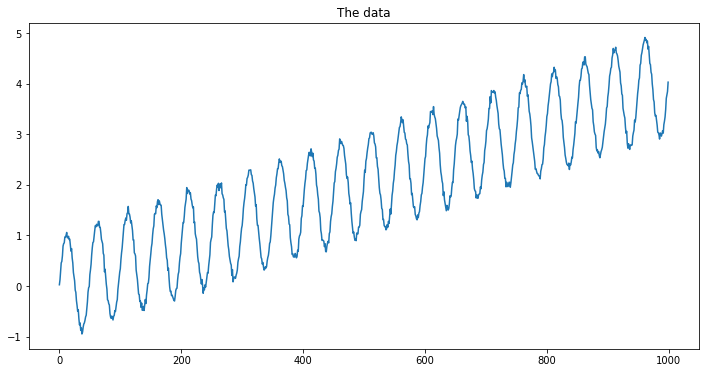

In [1589]:
plt.figure(figsize=(12, 6))
plt.plot(y_true)
plt.title("The data")

In [1552]:
# take a sample of the data
sample_indices = sorted(np.random.choice(len(y_true), size=600, replace=False))
y_sample = y_true[sample_indices]

In [1553]:
train_length = int(0.5 * len(y_sample))
data_length = len(y_sample)

In [1554]:
y_train = y_sample[:train_length]
y_test = y_sample[train_length:]

In [1555]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, window=5):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=window, center=True, min_periods=1)
    rolstd = pd.rolling_std(timeseries, window=window, center=True, min_periods=1)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Data')
    mean = plt.plot(rolmean, color='red', label='Mean Average(%d)' % window)
    ##std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Mean Average')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print(dfoutput)

### Test for stationarity using the Dickey-Fuller Test
- showing the rolling mean and the rolling standard deviation with window 120

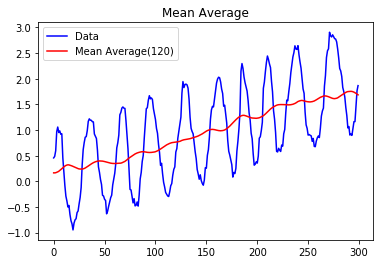

Results of Dickey-Fuller Test:
Test Statistic                  -2.152432
p-value                          0.223960
#Lags Used                      13.000000
Number of Observations Used    286.000000
Critical Value (1%)             -3.453423
Critical Value (5%)             -2.871699
Critical Value (10%)            -2.572183
dtype: float64


In [1556]:
test_stationarity(y_train, window=120)

There is an obvious rising trend in our data. We can remove it by subtracting the moving average from y.

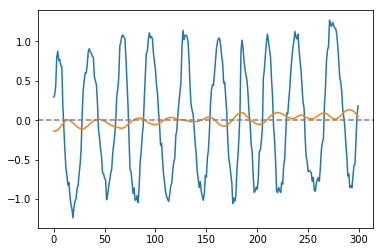

In [1562]:
y_ma = pd.rolling_mean(y_train, window=120, center=True, min_periods=1)
y_no_lag = y_train - y_ma
plt.plot(y_no_lag)
plt.plot(pd.rolling_mean(y_no_lag, window=120, center=True, min_periods=1))
plt.axhline(y=0.0, linestyle='--', color='gray')

The series looks stationary now.

In [1295]:
from statsmodels.tsa.arima_model import ARIMA

In [1296]:
y_test_ma = pd.rolling_mean(y_test, window=120, center=True, min_periods=1)
y_test_no_lag = y_test - y_test_ma

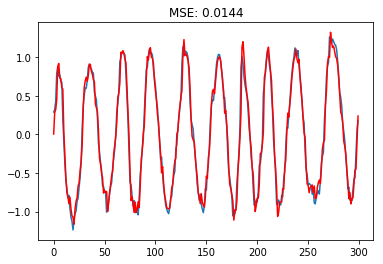

In [1563]:
model = ARIMA(y_no_lag, order=(2, 0, 2))  
results_AR = model.fit(disp=-1)
plt.plot(y_no_lag)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('MSE: %.4f'% sum((results_AR.fittedvalues-y_no_lag)**2/train_length))

In [1564]:
y_pred = results_AR.predict(train_length, data_length-1)

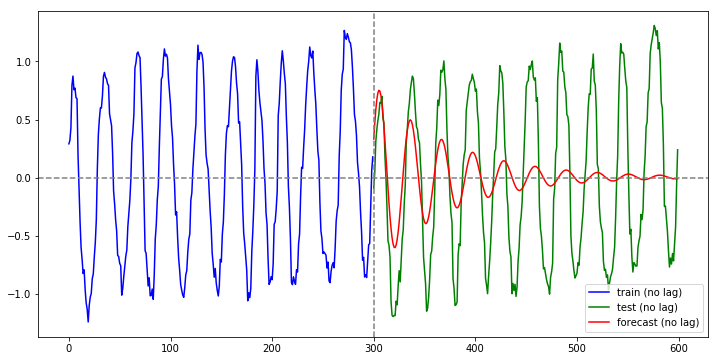

In [1566]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(train_length), y_no_lag, color='b', label="train (no lag)")
plt.plot(np.arange(train_length, data_length), y_test_no_lag, color='g',label="test (no lag)")
plt.plot(np.arange(train_length, data_length), y_pred, color='r', label="forecast (no lag)")
plt.axvline(x=train_length,linestyle='--',color='gray')
plt.axhline(y=0.0,linestyle='--',color='gray')
plt.legend()

Ok, but what if we don't want to explicitely remove moving average ?

We can try to differentiate the function assuming the trend is linear.

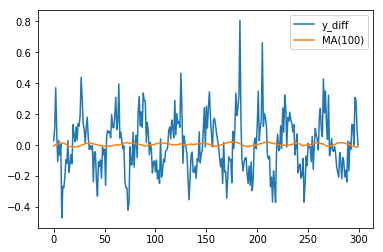

In [1567]:
y_diff = np.concatenate([np.diff(y_train), [0]])
plt.plot(y_diff, label="y_diff")
plt.plot(pd.rolling_mean(y_diff, 120, center=True, min_periods=1), label="MA(100)")
plt.legend()

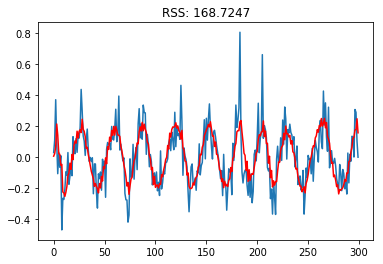

In [1568]:
model = ARIMA(y_diff, order=(5, 0, 6))
results_AR = model.fit(disp=-1)
plt.plot(y_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-y_no_lag)**2))

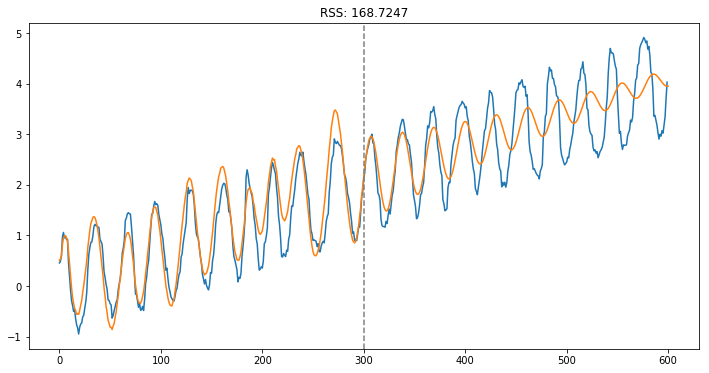

In [1571]:
plt.figure(figsize=(12, 6))
y_pred = results_AR.predict(train_length, data_length)
plt.plot(np.concatenate([y_train, y_test]))
plt.plot(0.5+np.concatenate([results_AR.fittedvalues, y_pred]).cumsum())
plt.axvline(x=train_length,linestyle='--',color='gray')
#plt.plot(results_AR.fittedvalues.cumsum(), color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-y_no_lag)**2))

Let ARIMA do the differentiation for us (set d = 1)

In [1648]:
model = ARIMA(y_train, order=(5, 1, 7))
results_AR = model.fit(disp=-1, method='mle')
print('MSE: %.4f'% sum((results_AR.fittedvalues-y_train[1:])**2/train_length))

MSE: 1.7094


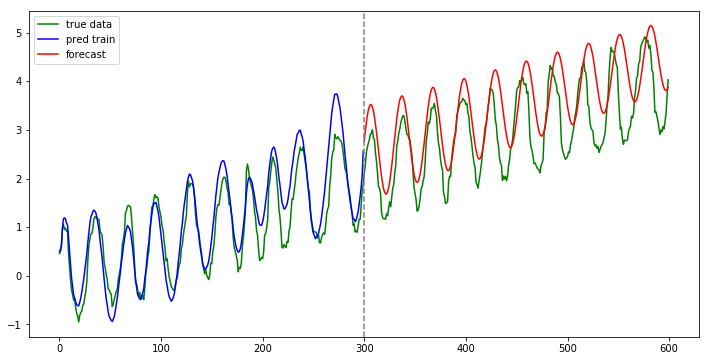

In [1650]:
plt.figure(figsize=(12, 6))
plt.plot(np.concatenate([y_train, y_test]), color='g', label="true data")
y_pred, y_stderr, y_conf = results_AR.forecast(data_length-train_length+1)
y_pred_cm = 0.5 + np.concatenate([results_AR.fittedvalues.cumsum(), y_pred])
plt.plot(np.arange(train_length), y_pred_cm[:train_length], color='b', label="pred train")
plt.plot(np.arange(train_length, data_length), y_pred_cm[train_length:], color='r', label="forecast")
plt.axvline(x=train_length,linestyle='--',color='gray')
plt.legend()

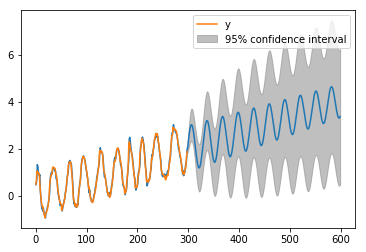

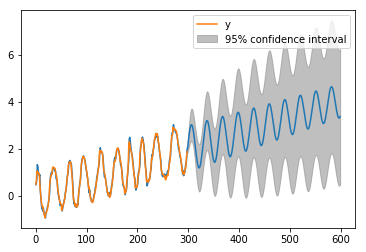

In [1651]:
results_AR.plot_predict(1, data_length)

### The errors

In [1652]:
y_valid = np.concatenate([y_train, y_test])
err = (y_pred_cm - y_valid).flatten()

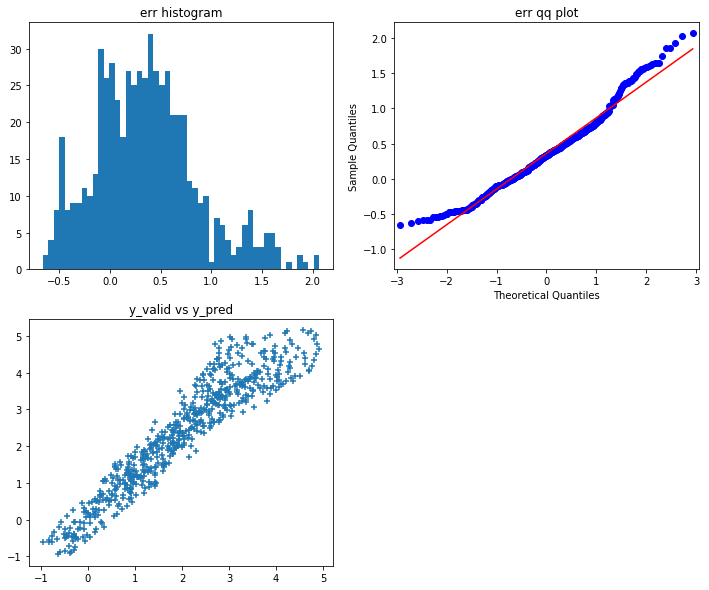

In [1653]:
plt.figure(figsize=(12, 10))
layout = (2, 2)
plt.subplot2grid(layout, (0, 0))
_ = plt.hist(err, bins=50)
plt.title('err histogram')
qq_ax = plt.subplot2grid(layout, (0, 1))
_ = sm.qqplot(err, line='s', ax=qq_ax)
plt.title('err qq plot')
plt.subplot2grid(layout, (1, 0))
plt.title("y_valid vs y_pred")
_ = plt.scatter(y_valid, y_pred_cm, marker='+')

# Looks good, but how do we choose p, d and q ?

Plot the _Autocorrelation Function_ and the _Partial Autocorrelation Function_ for different lag values.

The Autocorrelation shows 

In [1604]:
from statsmodels.tsa.stattools import acf, pacf

In [1605]:
lag_acf = acf(y_diff, nlags=20)
lag_pacf = pacf(y_diff, nlags=20, method='ols')

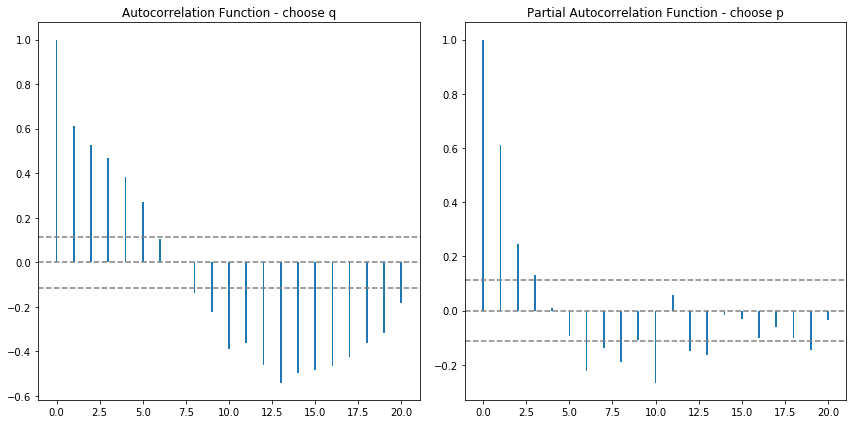

In [1606]:
plt.figure(figsize=(12, 6))
plt.subplot(121) 
plt.bar(np.arange(len(lag_acf)), lag_acf, width=0.1)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function - choose q')

plt.subplot(122)
plt.bar(np.arange(len(lag_pacf)), lag_pacf, width=0.1)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function - choose p')
plt.tight_layout()